# Test

### Imports

In [1]:
# Handling paths for importing code
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

from Code.utilities import MSELoss_method, plot_test_results, cross_entropy_loss_method
from Code.neural_network import _beta_init, get_neural_network_model
from Code.descent_methods import SGD_adam
from Code.data_handling import load_MNIST_28, append_run_to_file, load_run_from_file

from jax import jit, nn, grad
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

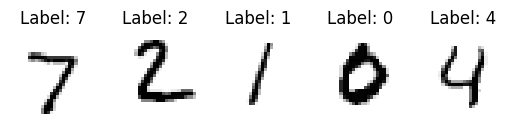

In [2]:
# download MNIST dataset
X_train, y_train, X_test, y_test = load_MNIST_28(flatten_images=True)

# Display some images
for i, image in enumerate(X_test[0:5]):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    n = int((image.shape[0])**(1/2))
    plt.imshow(image.reshape(n,n), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title(f"Label: {np.argmax(y_test[i])}")
plt.show()

### Training the neural network

In [3]:
# Make prediction function:
def predict(model, beta, X):
    """
    Returns the predicted number for each sample in X
    """

    # Use the neural network
    y = model(beta, X)

    # Find best guess index
    predictions = jnp.array([jnp.argmax(y_sample) for y_sample in y])

    return predictions


# Define new accuracy function
def accuracy_func(model, beta, X, y):
    """
    ACCURACY = percentage guessed correctly    
    """
    # Find indeces corresponding to ground truth
    predictions_gt = np.array([np.argmax(y_sample) for y_sample in y])
    predictions    = predict(model, beta, X)

    # return 1-jnp.mean(jnp.abs(predictions_gt-predictions))
    return float(np.sum(predictions_gt == predictions) / predictions.shape[0])

In [6]:
def softmax(out):
    # Softmax to get probabilities TODO: MULIG SLICINGA FUCKER OPP
    return jnp.exp(out) / jnp.sum(jnp.exp(out), axis=-1)[:, None]


def single_run(X_train, X_test, y_train, y_test, 
               lr, lam, hidden_layer_num, node_per_hidden, 
               hidden_activation, output_activation=softmax,
               epochs=300, batches=5,
               test_index=None, plot_or_not=False, result_filepath=None):
    
    """
    Performs a training with the given parameter

    Returns result, including the final accuracy scores
    """

    # Initialise beta and create the model
    layer_list = [X_train.shape[1]] + [node_per_hidden]*hidden_layer_num + [y_train.shape[1]]
    beta0 = _beta_init(layer_list)
    model = jit(get_neural_network_model(hidden_layer_num,activation=hidden_activation,
                                         output_activation=output_activation))

    # Create gradient from loss function. Ridge loss lets us use MSE by lam=0
    # loss_func = jit(ridge_loss_method(model=model, lam=lam))
    loss_func = jit(cross_entropy_loss_method(model=model, lam=lam))   
    loss_grad = jit(grad(loss_func))

    # MSE loss function for evaluation
    test_func = jit(MSELoss_method(model))
    test_func = loss_func

    # Perform training. We use adam, add the test index
    result = SGD_adam(X_train, y_train, X_test, y_test, 
                      grad_method=loss_grad,beta0=beta0, 
                      n_epochs=epochs, n_batches=batches,
                      test_loss_func= test_func, lr=lr)
    result.update({"test_index":test_index, "model":model, "X_test":X_test, "y_test":y_test})

    if plot_or_not:
        plot_test_results(result["test_loss_list"], result["train_loss_list"], 5, ylabel="MSE")

    # Add accuracy scores
    result["test_accuracy"]  = accuracy_func(model, result["beta_final"], X_test, y_test)
    result["train_accuracy"] = accuracy_func(model, result["beta_final"], X_train, y_train)

    # Also store the model for later use
    result["model"] = model

    if result_filepath:
        _list_to_store = [{"test_accuracy"     : result["test_accuracy"], 
                           "train_accuracy"    : result["train_accuracy"],
                           "lr"                : lr, 
                           "lam"               : lam,
                           "epochs"            : epochs,
                           "hidden_layer_num"  : hidden_layer_num, 
                           "node_per_hidden"   : node_per_hidden, 
                           "hidden_activation" : hidden_activation.__name__}]
        print(_list_to_store)
        append_run_to_file(result_filepath, _list_to_store)

    return result

epochs = 300
result = single_run(X_train, X_test, y_train, y_test, 
                    lr=0.01, lam=0.0001, hidden_layer_num=5, 
                    node_per_hidden=40, hidden_activation=nn.sigmoid, 
                    epochs=epochs, plot_or_not=True, 
                    result_filepath="test.json")

print("test: ", result["test_accuracy"])
print("train: ", result["train_accuracy"])

print("MSE test: ", result["test_loss_list"][-1])
print("MSE train: ", result["train_loss_list"][-1])

 15%|█▍        | 44/300 [00:56<05:29,  1.29s/it]

In [5]:
print(result["model"](result["beta_final"], X_train[0]))
print(y_train[0])

IndexError: Too many indices for array: 1 non-None/Ellipsis indices for dim 0.

### Architecture

In [ ]:
def hidden_node_hidden_layer_grid(savefig=False, nreps=5):
    lam = 1e-5
    lr = 0.01
    hidden_activation = nn.tanh
    hidden_activation_name = "tanh"
    
    # Maximal number of hidden layers and nodes
    n = 6
    # m = 19
    m = 60
    
    filename = filepath_location + f"lr={lr}_lambda={lam}_hidden_activation_func={hidden_activation_name}_nreps={nreps}__hidden_layer_num_grid_experiment_classification.png"

    fig, ax = plt.subplots(figsize=(9, 9))

    hidden_layer_numbers = np.arange(1, n + 1)
    nodes_per_layer_list = np.arange(1, m, m//n)

    # Arrays for storing the errors. temporary result to call result.get
    test_errs_all = np.zeros(shape=(n, n))
    train_errs_all = np.zeros(shape=(n, n))
    result = {}

    # Loop over nodes per layer
    for i, nodes_per_layer in enumerate(nodes_per_layer_list):
        print(f"nodes per layer: {nodes_per_layer}")
        
        # Loop over number of hidden layers
        for j, hidden_layer_number in enumerate(hidden_layer_numbers):
        
            # Accumulation variables for averaging over nreps
            s_test = 0.0
            s_train = 0.0
        
            # Run nreps times 
            for k in range(nreps):
                result = single_run(X, y, lr=lr, lam=lam, hidden_layer_num=hidden_layer_number, 
                                    node_per_hidden=nodes_per_layer, hidden_activation=hidden_activation, 
                                    test_index=result.get("test_index"))
                s_test += result["test_accuracy"]
                s_train += result["train_accuracy"]

            test_errs_all[i, j] = s_test/nreps
            train_errs_all[i, j] = s_train/nreps


    sns.heatmap(test_errs_all, annot=True, ax=ax, cmap="viridis", cbar=True)

    # Title
    ax.set_title("Final test accuracy")

    # Handle labels
    ax.set_xlabel("Number of hidden layers")
    ax.set_ylabel("Number of nodes per layer")

    ax.set_yticklabels(nodes_per_layer_list)
    ax.set_xticklabels(hidden_layer_numbers)
    

    plt.tight_layout()
    if savefig:
        fig.savefig(filename)
    plt.show()

    return {"hidden_layer_sizes":hidden_layer_numbers, "test_error":test_errs_all, "train_error":train_errs_all}

_ = hidden_node_hidden_layer_grid(savefig=True, nreps=1)

NameError: name 'filepath_location' is not defined

### Final model evaluation

We make confusion matrix ...

In [ ]:
epochs = 300
result = single_run(X, y, lr=0.01, lam=0.0001, hidden_layer_num=5, node_per_hidden=40, 
           hidden_activation=nn.sigmoid, epochs=epochs, test_index=test_index, plot_or_not=True)

print("test: ", result["test_accuracy"])
print("train: ", result["train_accuracy"])

print("MSE test: ", result["test_loss_list"][0][-1])
print("MSE train: ", result["train_loss_list"][0][-1])


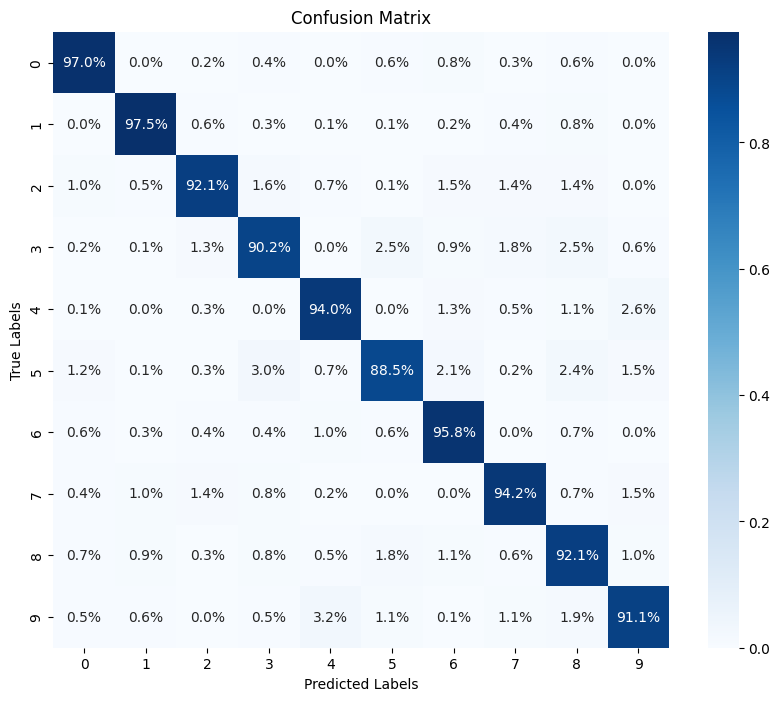

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Example true labels and predicted labels
nums_pred = predict(result["model"], result["beta_final"], X_test)
nums_gt   = jnp.array([jnp.argmax(y_sample) for y_sample in y_test])

# Create confusion matrix
conf_matrix = confusion_matrix(nums_gt, nums_pred)
conf_matrix = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt=".1%", cmap="Blues", square=True,
            xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

Also want to see exactly where the model fails ...

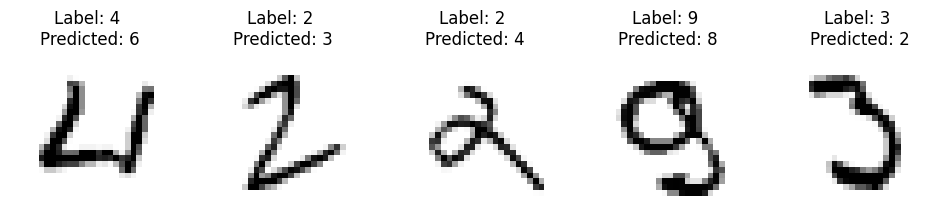

In [ ]:
# Format the faulty predictions back
indeces = nums_gt != nums_pred
imgs = [img.reshape(28, 28) for img in X_test[indeces]]
labels_pred = nums_pred[indeces]
labels_gt   = nums_gt[indeces]

# Plot the 5 first
for i, img in enumerate(imgs[0:5]):

    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(img, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title(f"Label: {labels_gt[i]} \nPredicted: {labels_pred[i]}")

plt.show()